In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from efficientnet_pytorch import EfficientNet
import torchvision.transforms as transforms
import pickle
import pandas as pd
from sklearn.model_selection import train_test_split
import os
from PIL import Image
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, average_precision_score
from sklearn.preprocessing import label_binarize
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

root_path = '/home/riddhi/Desktop/riddhi_workplace/GWAR_project'
model_directory = f'{root_path}/CLIP_Final/EfficientNet&CLIP/'

# Data prepare
feature_file = f"{root_path}/processed_image_features.pkl"
data_file = f"{root_path}/clean_dataset.csv"
image_dir = f"{root_path}/processed_images"

with open(feature_file, 'rb') as f:
    img_data = pickle.load(f)

clip_embeddings = img_data['image_feature']
img_files = img_data['files']
file_index_map = {file: idx for idx, file in enumerate(img_files)}
df = pd.read_csv(data_file)
df = df[['filename', 'quantity']]


# Split data into train+val and test
train_val, test = train_test_split(df, test_size=0.1, random_state=42)

# Split train+val into train and val
train, val = train_test_split(train_val, test_size=0.11, random_state=42)  # 0.11 x 0.9 ≈ 0.1 of the original data

# Generate train, test and validation tensors
clip_embedding_dim = 512

train_x, train_y, train_clip_embeddings = [], [], []
val_x, val_y, val_clip_embeddings = [], [], []
test_x, test_y, test_clip_embeddings = [], [], []


# Define image transformations
image_size = 224  # Adjust this based on the input size required by your model
mean = [0.485, 0.456, 0.406]  # ImageNet mean values
std = [0.229, 0.224, 0.225]  # ImageNet standard deviation values

image_transforms = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

for _, row in val.iterrows():
    image_path = os.path.join(image_dir, row['filename'])
    image = Image.open(image_path).convert('RGB')
    image = image_transforms(image)
    val_x.append(image)
    embedding_idx = file_index_map[row['filename']]
    val_clip_embeddings.append(clip_embeddings[embedding_idx, :])
    val_y.append(row['quantity'])

val_x = torch.stack(val_x)
val_y = torch.tensor(val_y, dtype=torch.long)
val_clip_embeddings = torch.stack(val_clip_embeddings)

for _, row in test.iterrows():
    image_path = os.path.join(image_dir, row['filename'])
    image = Image.open(image_path).convert('RGB')
    image = image_transforms(image)
    test_x.append(image)
    embedding_idx = file_index_map[row['filename']]
    test_clip_embeddings.append(clip_embeddings[embedding_idx, :])
    test_y.append(row['quantity'])

test_x = torch.stack(test_x)
test_y = torch.tensor(test_y, dtype=torch.long)
test_clip_embeddings = torch.stack(test_clip_embeddings)

# Data Loaders
val_dataset = TensorDataset(val_x, val_clip_embeddings, val_y)
test_dataset = TensorDataset(test_x, test_clip_embeddings, test_y)

batch_size = 1024
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Define the model
class ObjectCountingModel(nn.Module):
    def __init__(self, num_classes, clip_embedding_dim=512, efficient_net_model='efficientnet-b0'):
        super(ObjectCountingModel, self).__init__()
        self.efficient_net = EfficientNet.from_pretrained(efficient_net_model)
        self.clip_embedding_branch = nn.Sequential(
            nn.Linear(clip_embedding_dim, 256),
            nn.ReLU(),
            nn.Dropout(0.2)
        )
        # Get the output feature map size from the EfficientNet model
        dummy_input = torch.zeros(1, 3, 224, 224)
        efficient_net_feature_dim = self.efficient_net.extract_features(dummy_input).view(1, -1).shape[1]
        fusion_input_dim = efficient_net_feature_dim + 256
        fusion_output_dim = 512
        self.fusion = nn.Linear(fusion_input_dim, fusion_output_dim)
        self.classifier = nn.Linear(fusion_output_dim, num_classes)

    def forward(self, images, clip_embeddings):
        image_features = self.efficient_net.extract_features(images)
        image_features = image_features.view(image_features.size(0), -1)  # Flatten the image features
        clip_features = self.clip_embedding_branch(clip_embeddings)
        fused_features = torch.cat((image_features, clip_features), dim=1)
        fused_features = self.fusion(fused_features)
        logits = self.classifier(fused_features)
        return logits




In [ ]:
# Instantiate the model
num_classes = 6  # Number of object count classes (0, 1, 2, 3, 4, 5)
clip_embedding_dim = 512  # CLIP embedding dimensions
model = ObjectCountingModel(num_classes, clip_embedding_dim)

pth_files = [file for file in os.listdir(model_directory) if file.endswith('.pth')]

model_eval_data = {}
best_model_path = f"{model_directory}/efficient_net_clip_models/best_model_38.282828282828284.pth"
model.load_state_dict(torch.load(best_model_path))



Loaded pretrained weights for efficientnet-b0


<All keys matched successfully>

*******===============================*******
Validation dataset Performance
*******===============================*******
Overall Accuracy: 0.38
Mean Average Precision (mAP): 0.37
Average F1 Score: 0.38
Overall Precision: 0.38
Overall Recall: 0.38
Class 0 - Precision: 0.82, Recall: 0.97, F1 Score: 0.89, Average Precision: 0.80
Class 1 - Precision: 0.69, Recall: 0.55, F1 Score: 0.61, Average Precision: 0.46
Class 2 - Precision: 0.31, Recall: 0.44, F1 Score: 0.37, Average Precision: 0.24
Class 3 - Precision: 0.24, Recall: 0.12, F1 Score: 0.16, Average Precision: 0.22
Class 4 - Precision: 0.25, Recall: 0.32, F1 Score: 0.28, Average Precision: 0.21
Class 5 - Precision: 0.42, Recall: 0.42, F1 Score: 0.42, Average Precision: 0.30


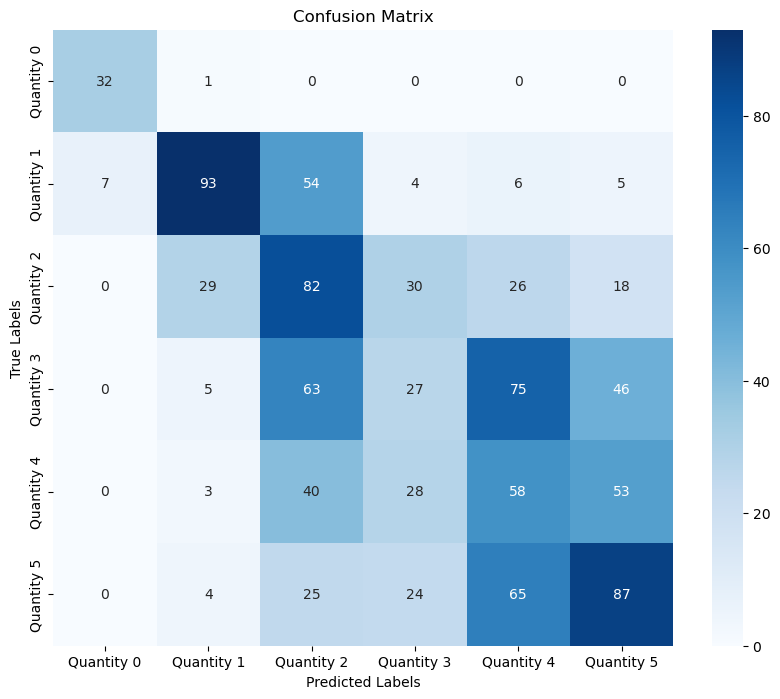

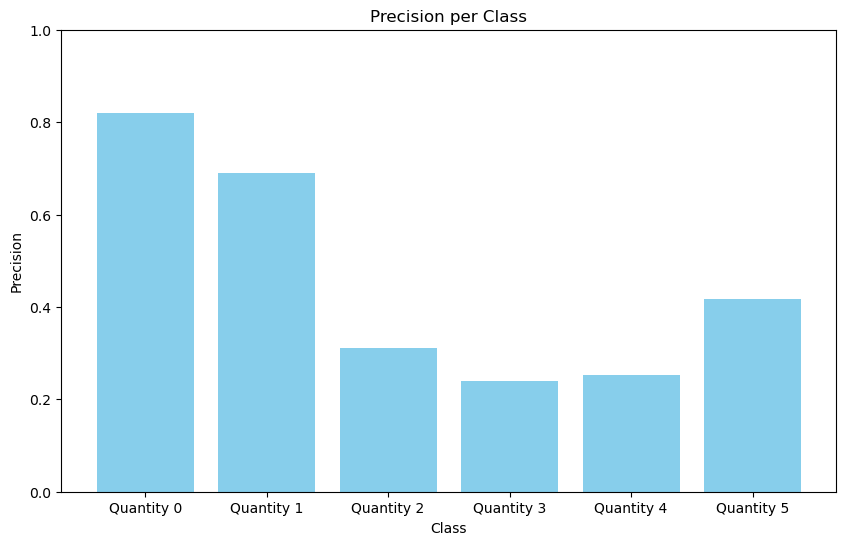

In [ ]:
# Val dataset performance
model.eval()
correct = 0
total = 0
all_labels = []
all_predictions = []
with torch.no_grad():
    for inputs, clip_embeddings, labels in val_loader:
        outputs = model(inputs, clip_embeddings)
        _, predicted = torch.max(outputs.data, 1)
        all_labels.extend(labels.tolist())
        all_predictions.extend(predicted.tolist())

# Binarize the labels for multi-class evaluation
Y_true = label_binarize(all_labels, classes=[0, 1, 2, 3, 4, 5])
Y_pred = label_binarize(all_predictions, classes=[0, 1, 2, 3, 4, 5])

# Compute the metrics for individual classes
accuracy = accuracy_score(Y_true, Y_pred)
precision_per_class = precision_score(Y_true, Y_pred, average=None)
recall_per_class = recall_score(Y_true, Y_pred, average=None)
f1_per_class = f1_score(Y_true, Y_pred, average=None)
conf_matrix = confusion_matrix(all_labels, all_predictions)

# Compute average precision for each class
average_precision_per_class = average_precision_score(Y_true, Y_pred, average=None)

# Compute mean average precision (mAP)
mean_average_precision = np.mean(average_precision_per_class)

# Print overall metrics
print("*******===============================*******")
print("Validation dataset Performance")
print("*******===============================*******")

print(f'Overall Accuracy: {accuracy:.2f}')
print(f'Mean Average Precision (mAP): {mean_average_precision:.2f}')
average_f1_score = f1_score(Y_true, Y_pred, average='weighted')
print(f'Average F1 Score: {average_f1_score:.2f}')

# Calculate overall precision and recall
overall_precision = precision_score(Y_true, Y_pred, average='samples')
overall_recall = recall_score(Y_true, Y_pred, average='samples')

# Print overall precision and recall
print(f'Overall Precision: {overall_precision:.2f}')
print(f'Overall Recall: {overall_recall:.2f}')

# Print metrics for each class
for i in range(num_classes):
    print(f'Class {i} - Precision: {precision_per_class[i]:.2f}, Recall: {recall_per_class[i]:.2f}, F1 Score: {f1_per_class[i]:.2f}, Average Precision: {average_precision_per_class[i]:.2f}')

# Optionally, save the model evaluation data including the new metrics
model_eval_data['best_model'] = {
    'test_accuracy': accuracy,
    'mean_average_precision': mean_average_precision,
    'precision': precision_per_class.tolist(),
    'recall': recall_per_class.tolist(),
    'f1_score': f1_per_class.tolist(),
    'average_precision': average_precision_per_class.tolist(),
    'confusion_matrix': conf_matrix.tolist()  # Convert numpy array to list for serialization if needed
}

# Generate Confusion Matrix Plot
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=[f'Quantity {i}' for i in range(num_classes)], yticklabels=[f'Quantity {i}' for i in range(num_classes)])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Generate Precision per Class Plot
plt.figure(figsize=(10, 6))
plt.bar(range(num_classes), precision_per_class, color='skyblue')
plt.xlabel('Class')
plt.ylabel('Precision')
plt.title('Precision per Class')
plt.xticks(range(num_classes), [f'Quantity {i}' for i in range(num_classes)])
plt.ylim(0, 1)
plt.show()


*******===============================*******
Test dataset Performance
*******===============================*******
Overall Accuracy: 0.41
Mean Average Precision (mAP): 0.38
Average F1 Score: 0.40
Overall Precision: 0.41
Overall Recall: 0.41
Class 0 - Precision: 0.89, Recall: 1.00, F1 Score: 0.94, Average Precision: 0.89
Class 1 - Precision: 0.65, Recall: 0.55, F1 Score: 0.59, Average Precision: 0.43
Class 2 - Precision: 0.34, Recall: 0.43, F1 Score: 0.38, Average Precision: 0.26
Class 3 - Precision: 0.27, Recall: 0.14, F1 Score: 0.18, Average Precision: 0.19
Class 4 - Precision: 0.29, Recall: 0.33, F1 Score: 0.31, Average Precision: 0.23
Class 5 - Precision: 0.40, Recall: 0.45, F1 Score: 0.43, Average Precision: 0.29


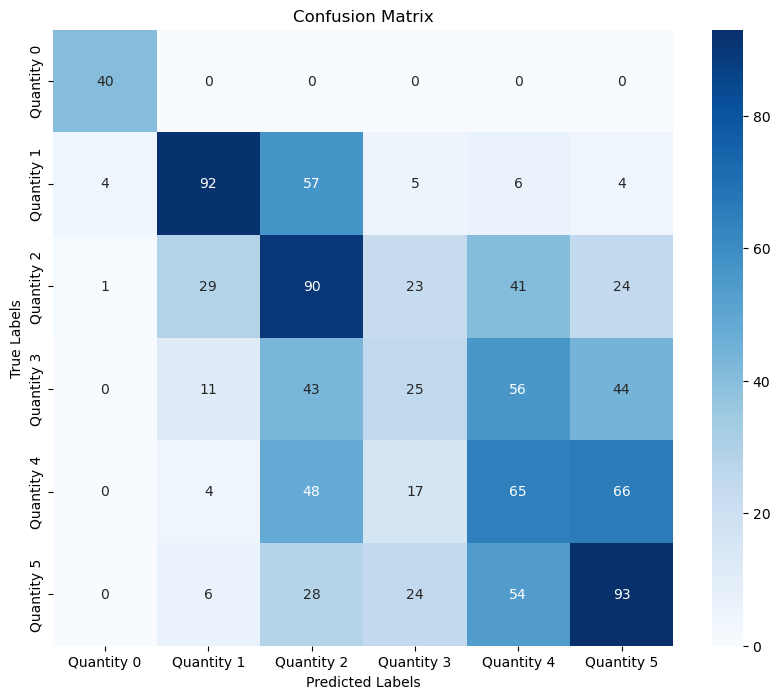

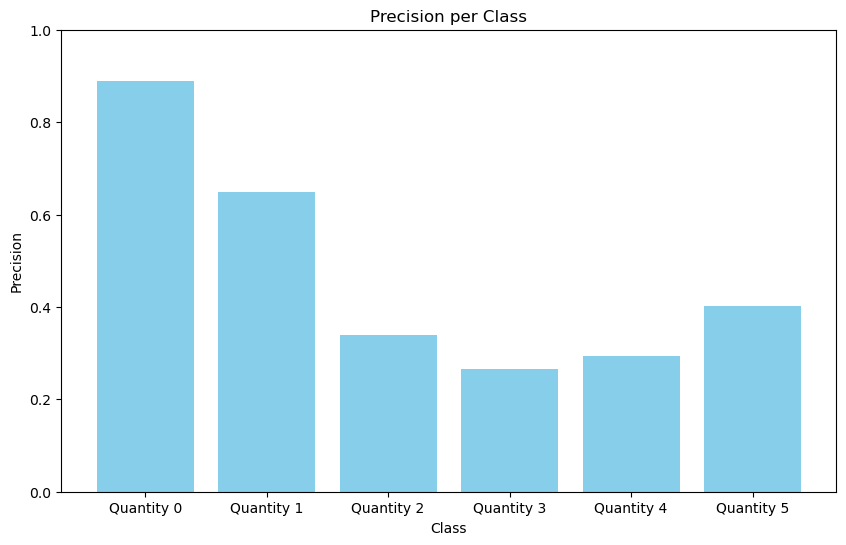

In [ ]:
# Test dataset performance
model.eval()
correct = 0
total = 0
all_labels = []
all_predictions = []
with torch.no_grad():
    for inputs, clip_embeddings, labels in test_loader:
        outputs = model(inputs, clip_embeddings)
        _, predicted = torch.max(outputs.data, 1)
        all_labels.extend(labels.tolist())
        all_predictions.extend(predicted.tolist())

# Binarize the labels for multi-class evaluation
Y_true = label_binarize(all_labels, classes=[0, 1, 2, 3, 4, 5])
Y_pred = label_binarize(all_predictions, classes=[0, 1, 2, 3, 4, 5])

# Compute the metrics for individual classes
accuracy = accuracy_score(Y_true, Y_pred)
precision_per_class = precision_score(Y_true, Y_pred, average=None)
recall_per_class = recall_score(Y_true, Y_pred, average=None)
f1_per_class = f1_score(Y_true, Y_pred, average=None)
conf_matrix = confusion_matrix(all_labels, all_predictions)

# Compute average precision for each class
average_precision_per_class = average_precision_score(Y_true, Y_pred, average=None)

# Compute mean average precision (mAP)
mean_average_precision = np.mean(average_precision_per_class)

# Print overall metrics
print("*******===============================*******")
print("Test dataset Performance")
print("*******===============================*******")

print(f'Overall Accuracy: {accuracy:.2f}')
print(f'Mean Average Precision (mAP): {mean_average_precision:.2f}')
average_f1_score = f1_score(Y_true, Y_pred, average='weighted')
print(f'Average F1 Score: {average_f1_score:.2f}')

# Calculate overall precision and recall
overall_precision = precision_score(Y_true, Y_pred, average='samples')
overall_recall = recall_score(Y_true, Y_pred, average='samples')

# Print overall precision and recall
print(f'Overall Precision: {overall_precision:.2f}')
print(f'Overall Recall: {overall_recall:.2f}')


# Print metrics for each class
for i in range(num_classes):
    print(f'Class {i} - Precision: {precision_per_class[i]:.2f}, Recall: {recall_per_class[i]:.2f}, F1 Score: {f1_per_class[i]:.2f}, Average Precision: {average_precision_per_class[i]:.2f}')

# Optionally, save the model evaluation data including the new metrics
model_eval_data['best_model'] = {
    'test_accuracy': accuracy,
    'mean_average_precision': mean_average_precision,
    'precision': precision_per_class.tolist(),
    'recall': recall_per_class.tolist(),
    'f1_score': f1_per_class.tolist(),
    'average_precision': average_precision_per_class.tolist(),
    'confusion_matrix': conf_matrix.tolist()  # Convert numpy array to list for serialization if needed
}


# Generate Confusion Matrix Plot
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=[f'Quantity {i}' for i in range(num_classes)], yticklabels=[f'Quantity {i}' for i in range(num_classes)])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Generate Precision per Class Plot
plt.figure(figsize=(10, 6))
plt.bar(range(num_classes), precision_per_class, color='skyblue')
plt.xlabel('Class')
plt.ylabel('Precision')
plt.title('Precision per Class')
plt.xticks(range(num_classes), [f'Quantity {i}' for i in range(num_classes)])
plt.ylim(0, 1)
plt.show()
